<a href="https://colab.research.google.com/github/dewith/brewerydatacup/blob/main/hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

# Brewery Data Cup - Colombia

En Bavaria queremos encontrar la mejor estrategia de impulso, mantenimiento o frenado, 
de un listado de marcas establecido, con el objetivo de ofrecer el mejor portafolio a nuestros 
puntos de venta/zonas dependiendo de sus características e historial de compra.

> **¿Qué construir?** <br> El objetivo es encontrar la probabilidad de que un cliente compre cada una de las marcas dadas, con el fin de asignar la estrategia adecuada a cada uno de ellos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Análisis exploratorio 

### 1.1 Importaciones
Importamos la librerías necesarias

In [ ]:
''' Data manipulation '''
import numpy as np
import pandas as pd

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline 


''' Machine Learning '''
# Scaling and tranformations
from sklearn.preprocessing import StandardScaler 

# Encoding
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Selection
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

Configuramos el estilo de los gráficos


In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette, rc=params)

### 1.2 Carga de datos

In [ ]:
df_estructura = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input1_clientes_estructura.csv', sep=';')
df_venta = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input2_clientes_venta.csv', sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/Hackaton/data/Input3_clientes_test.csv', sep=';')

In [ ]:
print('Shape de Estructura:', df_estructura.shape)
print('Shape de Ventas:', df_venta.shape)
print('Shape de Test:', df_test.shape)

Shape de Estructura: (20921, 6)
Shape de Ventas: (1406116, 10)
Shape de Test: (9302, 6)


Revisamos que no haya registros duplicados ni valores faltantes.

In [ ]:
for (name, df) in zip(['Estructura', 'Venta', 'Test'], [df_estructura, df_venta, df_test]):
    print('Valores duplicados en {}:'.format(name), end=' ')
    print(df.duplicated().sum())

Valores duplicados en Estructura: 0
Valores duplicados en Venta: 0
Valores duplicados en Test: 0


In [ ]:
for (name, df) in zip(['Estructura', 'Venta', 'Test'], [df_estructura, df_venta, df_test]):
    print('Valores faltantes en {}:'.format(name),)
    print('='*40)
    print(df.isna().sum(), '\n')

Valores faltantes en Estructura:
Cliente      0
Regional2    0
Gerencia2    0
SubCanal2    0
Categoria    0
Nevera       0
dtype: int64 

Valores faltantes en Venta:
Año                 0
Mes                 0
Cliente             0
SegmentoPrecio2     0
Marca2              0
Cupo2               0
CapacidadEnvase2    0
Volumen             0
disc                0
nr                  0
dtype: int64 

Valores faltantes en Test:
Cliente           0
Marca1         9302
Marca2         9302
Marca3         9302
Marca_Inno1    9302
Marca_Inno2    9302
dtype: int64 



El dataset de test está completamente vacío porque es lo nuestro modelo predecirá. POr lo tanto no hay que realizar ningún tipo de preprocesamiento al respecto.

### 1.3 Exploración de los datasets

#### 1.3.1 Estructura 

El dataset de **estrucutra** representa los datos y atributos de la base de clientes. Cada cliente es un establecimiento donde se comercian los productos: bares, tiendas, etc. 
- Cliente: Id del establecimiento
- Regional2: Región donde se encuentra ubicado
- Gerencia2: Gerencia que le distribuye el producto (Conjunto de 1, 2 o mas ciudades)
- SubCanal2: Tipo de establecimiento (Tienda, Bar, etc)
- Categoria: Variable usada AB-Inbev para calificar la importancia de un establecimiento dada su compra histórica.
- Nevera: Variable dummie que me permite ver si el establecimiento tiene o no una nevera en su punto de venta.

In [ ]:
df_estructura.describe(include='all')

,Cliente,Regional2,Gerencia2,SubCanal2,Categoria,Nevera
count,20921.000000,20921,20921,20921,20921,20921.000000
unique,NaN,1,11,32,6,NaN
top,NaN,Regional 1,Gerencia_10,Subcanal_3,Categoria_2,NaN
freq,NaN,20921,5441,8217,8773,NaN
mean,10461.000000,NaN,NaN,NaN,NaN,0.397830
std,6039.516827,NaN,NaN,NaN,NaN,0.489462
min,1.000000,NaN,NaN,NaN,NaN,0.000000
25%,5231.000000,NaN,NaN,NaN,NaN,0.000000
50%,10461.000000,NaN,NaN,NaN,NaN,0.000000
75%,15691.000000,NaN,NaN,NaN,NaN,1.000000


Con el anterior _describe_ podemos sacar algunas conclusiones:
- Todos los mismos clientes se encuentran en la misma región, por lo que esta variable no tendrá efecto en el modelo.
- Hay un total de 11 gerencias y 32 tipos de establecimiento.
- AB InBev maneja 6 categorías de establecimiento según su importancia comercial. Donde el más común, es la Categoria_2.
- Casi el 40% de los establecimientos tiene una nevera en su punto de venta.

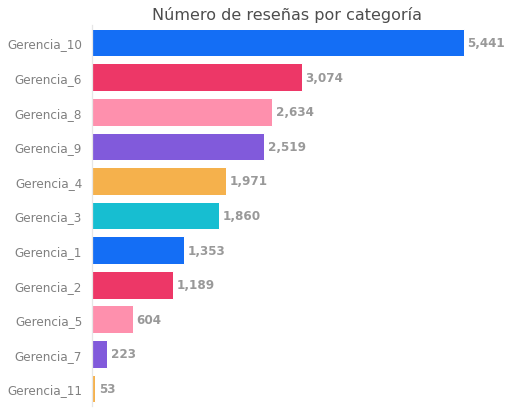

In [ ]:
def put_labels(X, text_format='{:,}', fontsize=12):
    '''
    Función para colocar labels en las barras
    '''
    padding = max(X) * 0.01
    for i, val in enumerate(X):
        ax.text(x=X[i]+padding,
                y=i,
                s=text_format.format(X[i]),
                va='center',
                ha='left',
                color='0.6',
                weight='bold',
                fontsize=fontsize)


#Hallamos el número de reseñas por categoría
category = df_estructura['Gerencia2'].value_counts()

# Creamos el gráfico
plt.figure(figsize=(7, 7))
ax = sns.barplot(x=category.values, 
                 y=category.index,
                 palette=palette, 
                 orient='h',
                 saturation=1,
                )

#change_height(ax, 0.87)
put_labels(category)
ax.set_title('Número de reseñas por categoría')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)

## Identificar las marcas

In [ ]:

conditions = [
  # Marca1: Marca_20 - Cupo_3 - CapacidadEnvase_9
  ( df_venta['Marca2'] == 'Marca_20') & ( df_venta['Cupo2'] == 'Cupo_3') & ( df_venta['CapacidadEnvase2'] == 'CapacidadEnvase_9'),
  # Marca2: Marca_16- Cupo_2 - CapacidadEnvase_10
  ( df_venta['Marca2'] == 'Marca_16') & ( df_venta['Cupo2'] == 'Cupo_2') & ( df_venta['CapacidadEnvase2'] == 'CapacidadEnvase_10'),
  # Marca3: Marca_9-Cupo_3-CapacidadEnvase_12
  ( df_venta['Marca2'] == 'Marca_9') & ( df_venta['Cupo2'] == 'Cupo_3') & ( df_venta['CapacidadEnvase2'] == 'CapacidadEnvase_12'),
  # Marca_Inno1: Marca_38- Cupo_2 -CapacidadEnvase_10
  ( df_venta['Marca2'] == 'Marca_38') & ( df_venta['Cupo2'] == 'Cupo_2') & ( df_venta['CapacidadEnvase2'] == 'CapacidadEnvase_10'),
  # Marca_Inno2: Marca_39-Cupo_2-CapacidadEnvase_10
  ( df_venta['Marca2'] == 'Marca_39') & ( df_venta['Cupo2'] == 'Cupo_2') & ( df_venta['CapacidadEnvase2'] == 'CapacidadEnvase_10'),
]


# Agrupar las marcas por sus carcateristicas para poder validar el producto
df_venta['producto'] = np.select(conditions, [1, 2, 3, 4, 5])

# Escoger los productos para analizar su comportamiento
ventas_totales =  df_venta.loc[ df_venta['producto'] != 0].reset_index(drop=True)

# Agrupar los valores de los productos para ver las ventas historicas totales
ventas_totales.groupby(['producto']).sum().nr

producto
1    2.883425e+06
2    4.912429e+06
3    7.826358e+07
4    1.535347e+07
5    9.243934e+06
Name: nr, dtype: float64

In [ ]:
df_venta.head(10)

,Año,Mes,Cliente,SegmentoPrecio2,Marca2,Cupo2,CapacidadEnvase2,Volumen,disc,nr,producto
0,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.112229,-30.590603,900.328567,0
1,2019,5,10,SegmentoPrecio_1,Marca_2,Cupo_2,CapacidadEnvase_10,0.021734,0.000000,149.184463,0
2,2019,5,10,SegmentoPrecio_2,Marca_3,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,359.625828,0
3,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_16,0.026345,-31.065261,134.748399,0
4,2019,5,10,SegmentoPrecio_1,Marca_4,Cupo_2,CapacidadEnvase_10,0.086938,0.000000,496.901005,0
5,2019,5,10,SegmentoPrecio_1,Marca_1,Cupo_2,CapacidadEnvase_10,0.369485,-114.891895,2853.911219,0
6,2019,5,10,SegmentoPrecio_1,Marca_5,Cupo_2,CapacidadEnvase_10,0.825907,-221.071444,6153.614786,0
7,2019,6,10,SegmentoPrecio_1,Marca_1,Cupo_1,CapacidadEnvase_12,0.036630,0.000000,303.759828,0
8,2019,5,10,SegmentoPrecio_2,Marca_6,Cupo_2,CapacidadEnvase_10,0.043469,0.000000,358.300464,0
9,2019,5,10,SegmentoPrecio_2,Marca_6,Cupo_1,CapacidadEnvase_10,0.004347,0.000000,43.469689,0


### 1.4 Preprocesado

In [ ]:
ventas = pd.merge(df_estructura, df_venta, on='Cliente', how='right')
ventas.shape

(1406116, 15)

In [ ]:
# Combinamos los productos en un solo atributo
ventas['Producto'] = ventas['Marca2'] + ' ' + ventas['Cupo2'] + ' ' + ventas['CapacidadEnvase2']
ventas.drop(['Regional2', 'Año', 'Mes', 'Marca2', 'Cupo2', 'CapacidadEnvase2'], axis=1, inplace=True)

# Remapeamos los productos de nuestra predición 
dicc = {'Marca_20 Cupo_3 CapacidadEnvase_9': 'Marca1',
        'Marca_16 Cupo_2 CapacidadEnvase_10':'Marca2',
        'Marca_9 Cupo_3 CapacidadEnvase_12': 'Marca3',
        'Marca_38 Cupo_2 CapacidadEnvase_10': 'Marca_Inno1',
        'Marca_39 Cupo_2 CapacidadEnvase_10': 'Marca_Inno2'}

ventas['Producto'] = ventas['Producto'].map(dicc).fillna(ventas['Producto'])

#Pasamos los productos a columnas
ventas = ventas.pivot_table('nr', ['Cliente', 'Gerencia2', 'SubCanal2', 'Categoria', 'Nevera'], 'Producto')      
ventas.reset_index(drop=False, inplace=True)
ventas.rename_axis(None, axis=1, inplace=True)
ventas.fillna(value=0, inplace=True)


def encode_units(x):
    if x <= 0:
        return 0
    if x > 0:
        return 1
ventas.iloc[:, 5:] = ventas.iloc[:, 5:].applymap(encode_units)
ventas.head()

,Cliente,Gerencia2,SubCanal2,Categoria,Nevera,Marca1,Marca2,Marca3,Marca_1 Cupo_1 CapacidadEnvase_12,Marca_1 Cupo_1 CapacidadEnvase_14,Marca_1 Cupo_1 CapacidadEnvase_6,Marca_1 Cupo_2 CapacidadEnvase_10,Marca_1 Cupo_2 CapacidadEnvase_16,Marca_1 Cupo_2 CapacidadEnvase_17,Marca_1 Cupo_2 CapacidadEnvase_5,Marca_10 Cupo_1 CapacidadEnvase_12,Marca_10 Cupo_2 CapacidadEnvase_10,Marca_11 Cupo_3 CapacidadEnvase_2,Marca_11 Cupo_3 CapacidadEnvase_3,Marca_12 Cupo_1 CapacidadEnvase_10,Marca_12 Cupo_1 CapacidadEnvase_12,Marca_12 Cupo_2 CapacidadEnvase_10,Marca_12 Cupo_3 CapacidadEnvase_10,Marca_13 Cupo_2 CapacidadEnvase_10,Marca_13 Cupo_3 CapacidadEnvase_10,Marca_14 Cupo_1 CapacidadEnvase_12,Marca_14 Cupo_2 CapacidadEnvase_10,Marca_14 Cupo_3 CapacidadEnvase_10,Marca_15 Cupo_1 CapacidadEnvase_10,Marca_15 Cupo_2 CapacidadEnvase_11,Marca_15 Cupo_2 CapacidadEnvase_16,Marca_16 Cupo_1 CapacidadEnvase_10,Marca_16 Cupo_1 CapacidadEnvase_12,Marca_16 Cupo_1 CapacidadEnvase_6,Marca_16 Cupo_3 CapacidadEnvase_10,Marca_16 Cupo_5 CapacidadEnvase_17,Marca_17 Cupo_1 CapacidadEnvase_10,Marca_17 Cupo_2 CapacidadEnvase_10,Marca_18 Cupo_1 CapacidadEnvase_10,Marca_18 Cupo_2 CapacidadEnvase_10,...,Marca_33 Cupo_3 CapacidadEnvase_10,Marca_34 Cupo_3 CapacidadEnvase_10,Marca_35 Cupo_3 CapacidadEnvase_10,Marca_36 Cupo_2 CapacidadEnvase_10,Marca_37 Cupo_2 CapacidadEnvase_4,Marca_4 Cupo_1 CapacidadEnvase_12,Marca_4 Cupo_1 CapacidadEnvase_14,Marca_4 Cupo_1 CapacidadEnvase_6,Marca_4 Cupo_2 CapacidadEnvase_10,Marca_4 Cupo_2 CapacidadEnvase_16,Marca_4 Cupo_2 CapacidadEnvase_17,Marca_4 Cupo_2 CapacidadEnvase_4,Marca_4 Cupo_3 CapacidadEnvase_10,Marca_4 Cupo_5 CapacidadEnvase_17,Marca_5 Cupo_1 CapacidadEnvase_10,Marca_5 Cupo_1 CapacidadEnvase_14,Marca_5 Cupo_1 CapacidadEnvase_6,Marca_5 Cupo_2 CapacidadEnvase_10,Marca_5 Cupo_2 CapacidadEnvase_16,Marca_5 Cupo_2 CapacidadEnvase_17,Marca_5 Cupo_2 CapacidadEnvase_5,Marca_5 Cupo_3 CapacidadEnvase_10,Marca_6 Cupo_1 CapacidadEnvase_10,Marca_6 Cupo_1 CapacidadEnvase_12,Marca_6 Cupo_1 CapacidadEnvase_6,Marca_6 Cupo_2 CapacidadEnvase_10,Marca_6 Cupo_3 CapacidadEnvase_10,Marca_6 Cupo_5 CapacidadEnvase_17,Marca_7 Cupo_1 CapacidadEnvase_12,Marca_7 Cupo_1 CapacidadEnvase_6,Marca_7 Cupo_3 CapacidadEnvase_5,Marca_7 Cupo_3 CapacidadEnvase_8,Marca_8 Cupo_1 CapacidadEnvase_6,Marca_8 Cupo_2 CapacidadEnvase_10,Marca_8 Cupo_3 CapacidadEnvase_1,Marca_8 Cupo_3 CapacidadEnvase_10,Marca_9 Cupo_3 CapacidadEnvase_15,Marca_9 Cupo_3 CapacidadEnvase_3,Marca_Inno1,Marca_Inno2
0,1,Gerencia_1,Subcanal_1,Categoria_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2,Gerencia_1,Subcanal_1,Categoria_1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,3,Gerencia_1,Subcanal_1,Categoria_1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,Gerencia_1,Subcanal_1,Categoria_1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
4,5,Gerencia_1,Subcanal_1,Categoria_2,1,1,0,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [ ]:
columns = ['Gerencia2', 'SubCanal2', 'Categoria']
try:
    for column in columns:
        ventas1[column] = ventas1[column].str.extract('(\d+)').astype(int)
except:
    pass
# not outliers
vent = ventas1.iloc[:, 4:]


Nevera                               1.0
Marca1                               0.0
Marca2                               0.0
Marca3                               1.0
Marca_1 Cupo_1 CapacidadEnvase_12    1.0
                                    ... 
Marca_8 Cupo_3 CapacidadEnvase_10    0.0
Marca_9 Cupo_3 CapacidadEnvase_15    0.0
Marca_9 Cupo_3 CapacidadEnvase_3     1.0
Marca_Inno1                          1.0
Marca_Inno2                          0.0
Length: 106, dtype: float64

# Resultado del modelo


In [ ]:
df_test['Cliente']

0          10
1          12
2          14
3          15
4          18
        ...  
9297    20186
9298    20261
9299    20309
9300    20360
9301    20569
Name: Cliente, Length: 9302, dtype: int64

In [ ]:
df_test

In [ ]:
test = pd.merge(df_estructura, df_test, on='Cliente', how='right')
test.drop(['Regional2'], axis=1, inplace=True)

In [ ]:
test.head()

,Cliente,Gerencia2,SubCanal2,Categoria,Nevera,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2
0,10,Gerencia_3,Subcanal_1,Categoria_2,1,NaN,NaN,NaN,NaN,NaN
1,12,Gerencia_3,Subcanal_4,Categoria_4,1,NaN,NaN,NaN,NaN,NaN
2,14,Gerencia_3,Subcanal_1,Categoria_2,1,NaN,NaN,NaN,NaN,NaN
3,15,Gerencia_2,Subcanal_3,Categoria_2,1,NaN,NaN,NaN,NaN,NaN
4,18,Gerencia_3,Subcanal_1,Categoria_5,1,NaN,NaN,NaN,NaN,NaN


In [225]:
X = ventas.iloc[:,1:5].copy()
y = ventas.iloc[:,5:].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=100)

In [226]:
# Creamos el preprocesador 
categorical_columns = ['Gerencia2', 'SubCanal2', 'Categoria']
preprocessor = make_column_transformer((OneHotEncoder(), categorical_columns),
                                       remainder="passthrough")

# Creamos el predictor 
bosque = RandomForestClassifier(random_state=100)

In [227]:
cols = ['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']

# Métricas
auc_train = []
auc_test = []

# Predcciones de probabilidades
y_train_pred = np.zeros((X_train.shape[0], y_train.shape[1]))
y_test_pred = np.zeros((X_test.shape[0], y_test.shape[1]))

for i, j in enumerate(cols):
    print ('Col {}'.format(j))
    
    #Entrenamos
    pipeline = make_pipeline(preprocessor, bosque)
    pipeline.fit(X_train, y_train.loc[:, j].values) 
    
    #Predecimos la probabilidad
    y_train_pred[:, i] = pipeline.predict_proba(X_train)[:, 1]
    y_test_pred[:, i] = pipeline.predict_proba(X_test)[:, 1]

    #Hallamos el área bajo la curva de cada estrella
    auc_train_col = roc_auc_score(y_train[j], y_train_pred[:, i]) #.loc[:, j].values
    auc_test_col = roc_auc_score(y_test[j], y_test_pred[:, i])
    print('ROC-AUC en train: {:.3f}'.format(auc_train_col))
    print('ROC-AUC en test: {:.3f}'.format(auc_test_col))
    auc_train.append(auc_train_col)
    auc_test.append(auc_test_col)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test))

Col Marca1
ROC-AUC en train: 0.761
ROC-AUC en test: 0.686
Col Marca2
ROC-AUC en train: 0.841
ROC-AUC en test: 0.745
Col Marca3
ROC-AUC en train: 0.788
ROC-AUC en test: 0.733
Col Marca_Inno1
ROC-AUC en train: 0.826
ROC-AUC en test: 0.788
Col Marca_Inno2
ROC-AUC en train: 0.820
ROC-AUC en test: 0.761

ROC-AUC promedio en el set de Train: 0.8073283294108275
ROC-AUC promedio en el set de Test: 0.7426611957987143


#### Todas los productos

In [228]:
# Creamos el pipeline
pipeline = make_pipeline(preprocessor, bosque)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Gerencia2', 'SubCanal2',
                                                   'Categoria'])],
                                   verbose=False)),
                ('rando...
                 RandomForestClassifier(

In [229]:
y_train_pred = pipeline.predict_proba(X_train)

preds = []
for cliente in range(y_train.shape[0]):
  lista = []
  #print('Cliente', cliente)
  for producto in range(y_train.shape[1]):
    #print(producto)
    lista.append(1 - (y_train_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_train_pred = pd.DataFrame(preds, columns=y_train.columns)

In [230]:
y_test_pred = pipeline.predict_proba(X_test)

preds = []
for cliente in range(y_test.shape[0]):
  lista = []
  #print('Cliente', cliente)
  for producto in range(y_test.shape[1]):
    #print(producto)
    lista.append(1 - (y_test_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_test_pred = pd.DataFrame(preds, columns=y_test.columns)

In [231]:
cols = ['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']

# Métricas
auc_train_all = []
auc_test_all = []

for i, j in enumerate(cols):
    print(j)
    #Hallamos el área bajo la curva de cada estrella
    auc_train_col = roc_auc_score(y_train[j], y_train_pred[j]) #.loc[:, j].values
    auc_test_col = roc_auc_score(y_test[j], y_test_pred[j])
    print('ROC-AUC en train: {:.3f}'.format(auc_train_col))
    print('ROC-AUC en test: {:.3f}'.format(auc_test_col))
    auc_train_all.append(auc_train_col)
    auc_test_all.append(auc_test_col)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train_all))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test_all))

Marca1
ROC-AUC en train: 0.761
ROC-AUC en test: 0.685
Marca2
ROC-AUC en train: 0.841
ROC-AUC en test: 0.741
Marca3
ROC-AUC en train: 0.788
ROC-AUC en test: 0.733
Marca_Inno1
ROC-AUC en train: 0.826
ROC-AUC en test: 0.788
Marca_Inno2
ROC-AUC en train: 0.820
ROC-AUC en test: 0.759

ROC-AUC promedio en el set de Train: 0.8073975875844717
ROC-AUC promedio en el set de Test: 0.7410179216505786


### Modelo final

In [232]:
X_train = ventas.iloc[:,1:5].copy()
y_train = ventas.iloc[:,5:].copy()
X_test = test.iloc[:,1:5].copy()

In [233]:
# Creamos el pipeline
pipeline = make_pipeline(preprocessor, bosque)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Gerencia2', 'SubCanal2',
                                                   'Categoria'])],
                                   verbose=False)),
                ('rando...
                 RandomForestClassifier(

In [235]:
y_test_pred = pipeline.predict_proba(X_test)

preds = []
for cliente in range(X_test.shape[0]):
  lista = []
  #print('Cliente', cliente)
  for producto in range(y_train.shape[1]):
    #print(producto)
    lista.append(1 - (y_test_pred[producto][cliente][0]))
  preds.append(lista)
preds = np.array(preds)
y_test_pred = pd.DataFrame(preds, columns=y_train.columns)

In [246]:
cols = ['Marca1', 'Marca2', 'Marca3', 'Marca_Inno1', 'Marca_Inno2']
df_test[cols] = y_test_pred[cols]

In [247]:
df_test.head()

,Cliente,Marca1,Marca2,Marca3,Marca_Inno1,Marca_Inno2
0,10,0.296739,0.302953,0.744662,0.196949,0.099205
1,12,0.141709,0.573783,0.889801,0.174804,0.027062
2,14,0.296739,0.302953,0.744662,0.196949,0.099205
3,15,0.378536,0.077782,0.516931,0.160692,0.055421
4,18,0.919364,0.038153,0.958217,0.461528,0.014754


In [252]:
df_test.to_csv(path_or_buf='/content/drive/MyDrive/Hackaton/test.csv')